In [1]:
import numpy as np
import pygad
from scipy.integrate import solve_ivp

In [17]:
def simulator(theta):
    k_P, k_alpha, Q_g, Q_l = theta

    Q_out = 0.05
    P0 = 5e6
    alpha0 = 0.2

    def rhs(t, y):
        P, alpha = y
        dP_dt = k_P * (Q_g - alpha * Q_out)
        d_alpha_dt = k_alpha * ((Q_g / (Q_g + Q_l)) - alpha)
        return [dP_dt, d_alpha_dt]

    t_span = (0, 200)
    t_eval = np.linspace(*t_span, 200)
    sol = solve_ivp(rhs, t_span, [P0, alpha0], t_eval=t_eval)

    if not sol.success:
        raise RuntimeError("Simulation failed")

    return sol.y.flatten()

In [55]:
theta_true = [1.5e3, 0.3, 0.03, 0.02]
observed = simulator(theta_true)

In [56]:
def fitness_func(ga_instance, solution, solution_idx):
    try:
        sim = simulator(solution)
        mse = np.mean((sim - observed) ** 2)
        return -mse  # PyGAD maximizes fitness, so we return negative MSE
    except:
        return -1e12  # Penalize failed simulations

In [57]:
gene_space = [
    {'low': 1e3, 'high': 1e4},   # k_P
    {'low': 0.1, 'high': 1.0},   # k_alpha
    {'low': 0.01,  'high': 0.1},  # Q_g
    {'low': 0.01,  'high': 0.1},  # Q_l
]

In [66]:
ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=10,
    fitness_func=fitness_func,
    sol_per_pop=20,
    num_genes=4,
    gene_space=gene_space,
    mutation_percent_genes=50,
    mutation_type="random",
    crossover_type="single_point",
    allow_duplicate_genes=False,
    random_mutation_min_val=-0.01,
    random_mutation_max_val=0.01,
    stop_criteria="saturate_20"
)

In [67]:
ga_instance.run()

In [64]:
solution, solution_fitness, _ = ga_instance.best_solution()

In [65]:
print(f"Estimated parameters: {solution}")
print(f"True parameters:      {theta_true}")
print(f"Fitness (MSE):       {-solution_fitness}")

Estimated parameters: [1.46529107e+03 9.14052981e-01 2.35198858e-02 2.70323361e-02]
True parameters:      [1500.0, 0.3, 0.03, 0.02]
Fitness (MSE):       988.7760581394105


/home/sam/miniconda3/envs/pandora/lib/python3.12/site-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


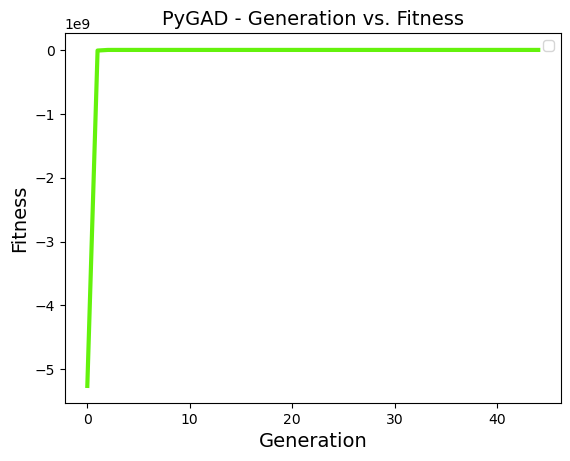

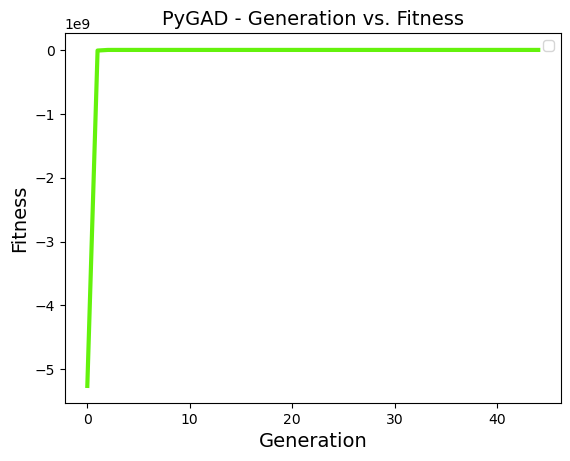

In [54]:
ga_instance.plot_fitness()

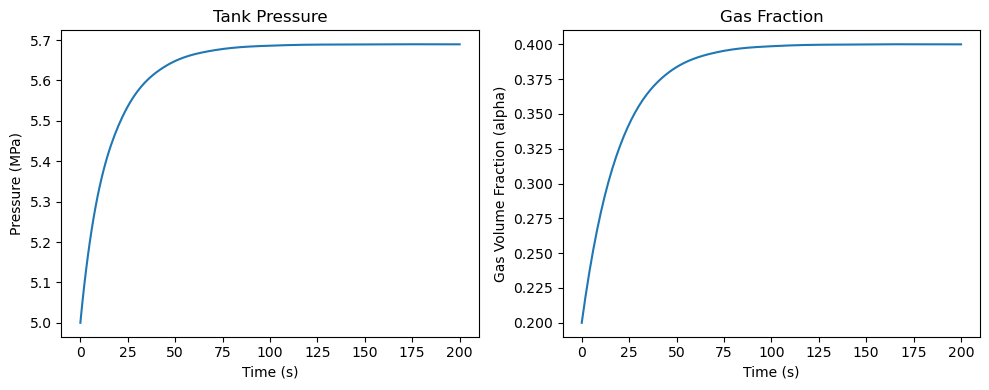

In [89]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def two_phase_tank(theta, t_span=(0, 200), num_points=200):
    """
    Basic simulator for a two-phase (gas-liquid) tank.
    
    Parameters:
    - theta: list of model parameters [k_P, k_alpha, Q_g_in, Q_l_in]
    - t_span: time interval for simulation
    - num_points: number of time evaluation points
    
    Returns:
    - t: time vector
    - P: pressure over time
    - alpha: gas volume fraction over time
    """

    k_P, k_alpha, Q_g_in, Q_l_in = theta
    
    # Fixed parameters
    V_total = 1.0       # Total volume of the tank (m^3)
    Q_out = 0.05        # Constant outflow (m^3/s)
    P0 = 5e6            # Initial pressure (Pa)
    alpha0 = 0.2        # Initial gas volume fraction

    def rhs(t, y):
        P, alpha = y

        # Effective outflow distribution (split proportional to volume fractions)
        Q_g_out = Q_out * alpha
        Q_l_out = Q_out * (1 - alpha)

        # Gas and liquid accumulation
        dP_dt = k_P * ((Q_g_in - Q_g_out) / (alpha + 1e-6))
        d_alpha_dt = k_alpha * ((Q_g_in / (Q_g_in + Q_l_in + 1e-8)) - alpha)

        return [dP_dt, d_alpha_dt]

    t_eval = np.linspace(*t_span, num_points)
    sol = solve_ivp(rhs, t_span, [P0, alpha0], t_eval=t_eval)

    if not sol.success:
        raise RuntimeError("Integration failed.")

    return sol.t, sol.y[0], sol.y[1]  # t, P, alpha

# Example usage
theta = [1e6, 0.05, 0.02, 0.03]
t, P, alpha = two_phase_tank(theta)

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, P / 1e6)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (MPa)')
plt.title('Tank Pressure')

plt.subplot(1, 2, 2)
plt.plot(t, alpha)
plt.xlabel('Time (s)')
plt.ylabel('Gas Volume Fraction (alpha)')
plt.title('Gas Fraction')

plt.tight_layout()
plt.show()

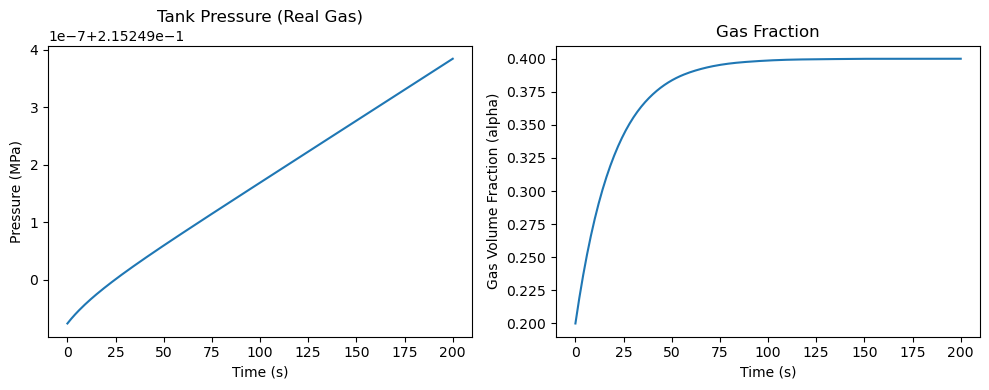

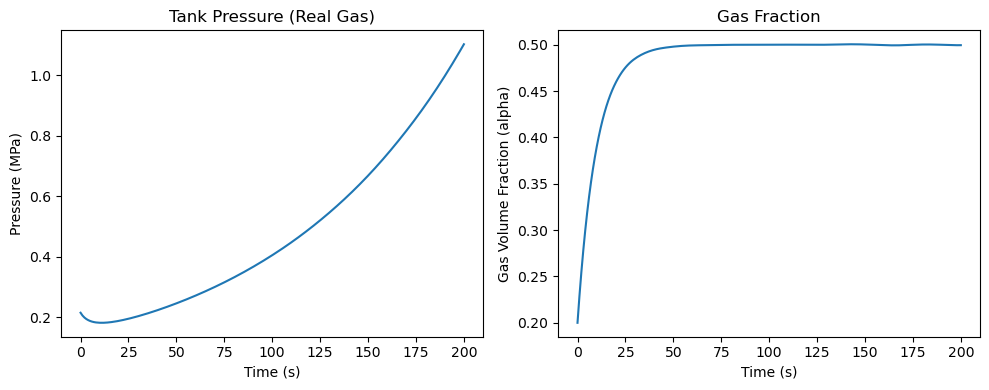

In [135]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def two_phase_tank_real_gas(theta, t_span=(0, 200), num_points=200):
    """
    Two-phase tank simulator with real gas dynamics (ideal gas law).
    
    Parameters:
    - theta: [k_alpha, Q_g_in, Q_l_in]
    """
    k_alpha, Q_g_in, Q_l_in = theta

    # Constants
    V_total = 1.0           # m^3
    R = 287.0               # J/(kg·K) for air
    T = 300.0               # Kelvin
    Q_out = 0.05            # m^3/s, total outflow
    m_gas0 = 0.5            # initial gas mass (kg)
    alpha0 = 0.2            # initial gas volume fraction

    def rhs(t, y):
        m_gas, alpha = y

        V_gas = alpha * V_total
        P = (m_gas * R * T) / (V_gas + 1e-6)  # prevent divide-by-zero

        # Flow splits
        Q_g_out = Q_out * alpha
        Q_l_out = Q_out * (1 - alpha)

        # Gas density (ideal)
        rho_g = m_gas / (V_gas + 1e-6)

        # Rate of change of gas mass
        dm_gas_dt = Q_g_in * rho_g - Q_g_out * rho_g

        # Alpha dynamics (driven by inflow composition)
        d_alpha_dt = k_alpha * ((Q_g_in / (Q_g_in + Q_l_in + 1e-8)) - alpha)

        return [dm_gas_dt, d_alpha_dt]

    t_eval = np.linspace(*t_span, num_points)
    sol = solve_ivp(rhs, t_span, [m_gas0, alpha0], t_eval=t_eval)

    if not sol.success:
        raise RuntimeError("Integration failed.")

    # Reconstruct pressure
    m_gas, alpha = sol.y
    P = (m_gas * R * T) / (alpha * V_total + 1e-6)

    return sol.t, P, alpha

# Example usage
theta = [0.1, 0.03, 0.03]  # k_alpha, Q_g_in, Q_l_in
t, P, alpha = two_phase_tank_real_gas(theta)

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, P / 1e6)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (MPa)')
plt.title('Tank Pressure (Real Gas)')

plt.subplot(1, 2, 2)
plt.plot(t, alpha)
plt.xlabel('Time (s)')
plt.ylabel('Gas Volume Fraction (alpha)')
plt.title('Gas Fraction')

plt.tight_layout()
plt.show()

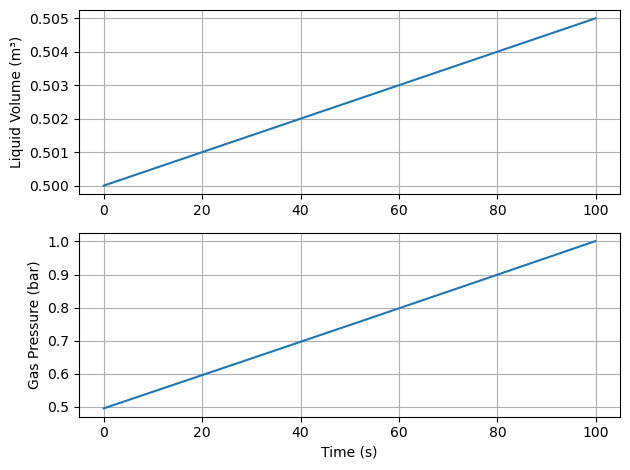

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
V_tank = 1.0          # m^3
rho_l = 1000.0        # kg/m^3 (e.g. water)
R = 8.314             # J/mol-K
T = 298.15            # K

# Simulation parameters
dt = 0.1              # time step (s)
t_final = 100         # total simulation time (s)
n_steps = int(t_final / dt)

# Initial conditions
V_l = 0.5             # Initial liquid volume (m^3)
n_g = 10.0            # Initial moles of gas (mol)

# Inlet/Outlet Flows (can modify to functions)
m_l_in = 0.1          # kg/s
m_l_out = 0.05        # kg/s
n_g_in = 0.2          # mol/s
n_g_out = 0.1         # mol/s

# Storage for plotting
time = []
V_l_hist = []
P_hist = []

# Simulation loop
for step in range(n_steps):
    t = step * dt
    V_g = V_tank - V_l
    if V_g <= 0.0:
        raise ValueError("Gas volume collapsed! Liquid overfilled the tank.")

    P = n_g * R * T / V_g

    # Store values
    time.append(t)
    V_l_hist.append(V_l)
    P_hist.append(P / 1e5)  # Convert to bar

    # Update volumes and moles using Euler method
    dV_l = (m_l_in - m_l_out) / rho_l * dt
    dn_g = (n_g_in - n_g_out) * dt

    V_l += dV_l
    n_g += dn_g

    # Safety check
    if V_l < 0:
        V_l = 0.0
    if V_l > V_tank:
        V_l = V_tank

# Plotting
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time, V_l_hist)
plt.ylabel("Liquid Volume (m³)")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, P_hist)
plt.ylabel("Gas Pressure (bar)")
plt.xlabel("Time (s)")
plt.grid()
plt.tight_layout()
plt.show()

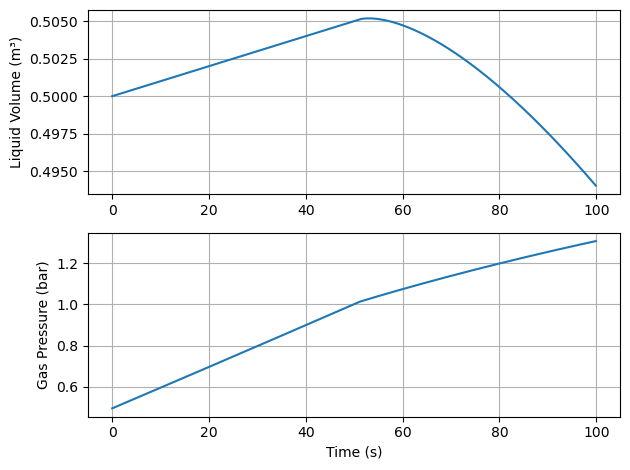

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
V_tank = 1.0            # m^3
rho_l = 1000.0          # kg/m^3
R = 8.314               # J/mol-K
T = 298.15              # K
P_atm = 101325          # Pa

# Valve parameters
Cd_l = 0.62             # Liquid discharge coefficient
A_l = 1e-4              # Liquid valve area (m^2)
Cv_g = 1e-5             # Gas valve Cv equivalent (mol/s·Pa)

# Simulation settings
dt = 0.1
t_final = 100
n_steps = int(t_final / dt)

# Initial conditions
V_l = 0.5
n_g = 10.0

# Constant inlet
m_l_in = 0.1            # kg/s
n_g_in = 0.2            # mol/s

# Data storage
time, V_l_hist, P_hist = [], [], []

for step in range(n_steps):
    t = step * dt
    V_g = V_tank - V_l
    if V_g <= 0.0:
        raise ValueError("Tank overflow: no gas space left.")
    
    # Ideal gas pressure
    P = n_g * R * T / V_g
    
    # Liquid outlet mass flow (only if P > P_atm)
    if P > P_atm:
        m_l_out = Cd_l * A_l * np.sqrt(2 * rho_l * (P - P_atm))
    else:
        m_l_out = 0.0

    # Gas outlet molar flow (simplified)
    if P > P_atm:
        n_g_out = Cv_g * P / np.sqrt(T)
    else:
        n_g_out = 0.0

    # Log current state
    time.append(t)
    V_l_hist.append(V_l)
    P_hist.append(P / 1e5)  # bar

    # Update state
    dV_l = (m_l_in - m_l_out) / rho_l * dt
    dn_g = (n_g_in - n_g_out) * dt

    V_l += dV_l
    n_g += dn_g

    # Limits
    V_l = np.clip(V_l, 0.0, V_tank)
    n_g = max(n_g, 0.0)

# Plotting
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time, V_l_hist)
plt.ylabel("Liquid Volume (m³)")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, P_hist)
plt.ylabel("Gas Pressure (bar)")
plt.xlabel("Time (s)")
plt.grid()
plt.tight_layout()
plt.show()

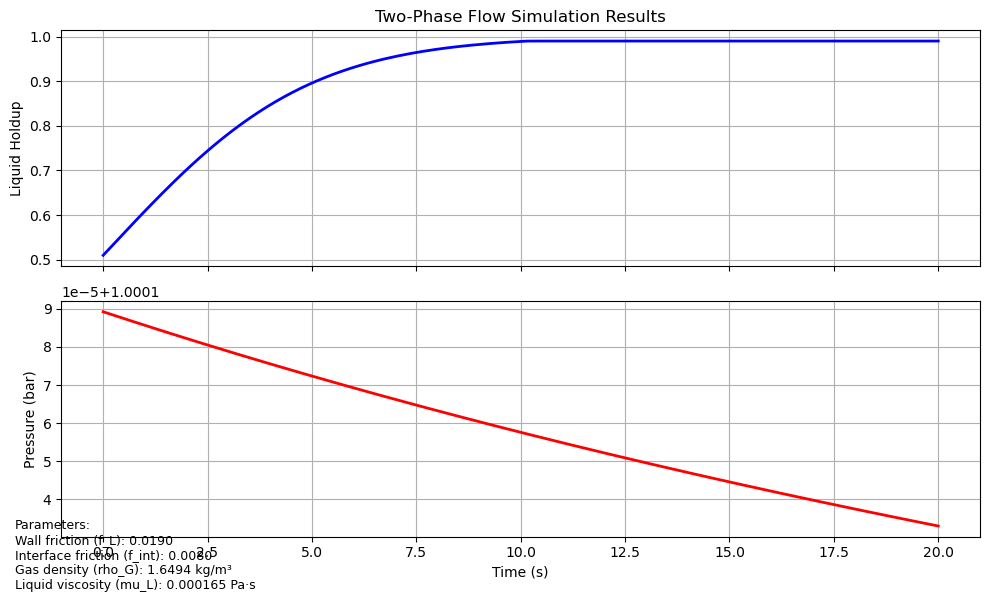

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def sample_parameters():
    # Sample parameters from uniform priors
    f_L = np.random.uniform(0.005, 0.1)       # wall friction
    f_int = np.random.uniform(0.005, 0.05)    # interface friction
    rho_G = np.random.uniform(0.5, 2.5)       # gas density
    mu_L = np.random.uniform(1e-4, 1e-2)      # liquid viscosity
    return [f_L, f_int, rho_G, mu_L]

def two_phase_simulator_with_physical_holdup(theta, T=20.0, dt=0.1):
    f_L, f_int, rho_G, mu_L = theta

    rho_L = 1000.0
    p_outlet = 1e5
    alpha_L = 0.5
    u_L = 1.0
    u_G = 5.0

    lambda_holdup = 0.1

    N = int(T / dt)
    alpha_series = np.zeros(N)
    pressure_series = np.zeros(N)

    for t in range(N):
        tau_int = 0.5 * f_int * rho_G * (u_L - u_G) ** 2
        tau_wall_L = 0.5 * f_L * rho_L * u_L ** 2

        du_L = (-tau_wall_L - tau_int) / rho_L
        du_G = (+tau_int) / max(rho_G, 1e-5)

        u_L += dt * du_L
        u_G += dt * du_G

        u_L = np.clip(u_L, -100.0, 100.0)
        u_G = np.clip(u_G, -100.0, 100.0)

        d_alpha_L = lambda_holdup * (u_G - u_L) * alpha_L * (1 - alpha_L)
        alpha_L = np.clip(alpha_L + dt * d_alpha_L, 0.01, 0.99)

        pressure = p_outlet + 1000 * f_L * u_L ** 2
        pressure = np.clip(pressure, 0, 1e7)

        alpha_series[t] = alpha_L
        pressure_series[t] = pressure

    return alpha_series, pressure_series
# Generate and return the results for inspection
theta = sample_parameters()
alpha_ts, pressure_ts = two_phase_simulator_with_physical_holdup(theta)

import pandas as pd
df = pd.DataFrame({
    "Time (s)": np.linspace(0, 20, len(alpha_ts)),
    "Liquid Holdup": alpha_ts,
    "Pressure (Pa)": pressure_ts
})

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot Liquid Holdup
ax1.plot(df['Time (s)'], df['Liquid Holdup'], 'b-', linewidth=2)
ax1.set_ylabel('Liquid Holdup')
ax1.set_title('Two-Phase Flow Simulation Results')
ax1.grid(True)

# Plot Pressure
ax2.plot(df['Time (s)'], df['Pressure (Pa)']/1e5, 'r-', linewidth=2)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Pressure (bar)')
ax2.grid(True)

# Print simulation parameters
param_text = f"Parameters:\nWall friction (f_L): {theta[0]:.4f}\nInterface friction (f_int): {theta[1]:.4f}\nGas density (rho_G): {theta[2]:.4f} kg/m³\nLiquid viscosity (mu_L): {theta[3]:.6f} Pa·s"
plt.figtext(0.02, 0.01, param_text, fontsize=9)

plt.tight_layout()
plt.show()